# Import Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd

mon_features_modified = pd.read_csv('/content/drive/MyDrive/Machine_Learning/mon_features_modified.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/Machine_Learning/mon_labels.csv')

unmon_features_modified = pd.read_csv('/content/drive/MyDrive/Machine_Learning/unmon_features_modified.csv')
unmon_labels = pd.read_csv('/content/drive/MyDrive/Machine_Learning/unmon_labels.csv')

In [9]:
import numpy as np

features_modified = pd.concat([mon_features_modified, unmon_features_modified], ignore_index=True)

features_modified = features_modified.drop(['alternative_packets_per_second_sum', 'transmission_time_Q2','med_packets_per_second','transmission_time_Q1','mean_packets_per_second'], axis=1)

mon_labels = np.ones(len(mon_features_modified))
unmon_labels = -np.ones(len(unmon_features_modified))
labels = np.concatenate([mon_labels, unmon_labels])

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def scaler_samples(train_X,test_X):
  scaler = StandardScaler()
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

X_train, X_test, y_train, y_test = train_test_split(
    features_modified, labels, test_size=0.2, random_state=1
)

scaler_samples(X_train, X_test)

# Building Random Forest Model

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_binary = RandomForestClassifier(n_jobs = -1)

rf_binary.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = rf_binary.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix\n {conf_matrix}")

Accuracy: 0.8508620689655172
Confusion Matrix
 [[1396  536]
 [ 329 3539]]


# Hyperparameter Tuning with GridSearchCV
In the experiment results below, the server was down due to the Colab environment, so the results of the experiment using another server are attached.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [2500, 3000, 3500, 4000],
    'max_depth': [200, 250, 300, 350, 400],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'max_leaf_nodes' : [2000, 2500, 3000],
    'class_weight' : ['balanced']
}

grid_search = GridSearchCV(estimator=rf_binary, param_grid=param_grid, cv=5)

grid_search.fit(X_test, y_test)

In [ ]:
crves = grid_search.cv_results_
for mean_score, params in zip(crves["mean_test_score"], crves["params"]):
    print(mean_score, params)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Model:", best_model)
y_pred = best_model.predict(X_test)

Best Hyperparameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 400, 'max_features': 'sqrt', 'max_leaf_nodes': 3000, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3000}
Best Model: RandomForestClassifier(class_weight='balanced', max_depth=400,
                       max_leaf_nodes=3000, n_estimators=3000, n_jobs=-1)

# Evaluation Metrics

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix\n {conf_matrix}")

Accuracy: 0.8520689655172414

Confusion Matrix

 [[1377  555]

 [ 303 3565]]

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
precision_values, recall_values, thresholds_pr = precision_recall_curve(y_test, y_pred, pos_label=1)
pr_auc = auc(recall_values, precision_values)

print(f"True Positive Rate (TPR): {tpr[1]}")
print(f"False Positive Rate (FPR): {fpr[1]}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")
print(f"Precision-Recall AUC: {pr_auc}")

True Positive Rate (TPR): 0.921664943123061

False Positive Rate (FPR): 0.28726708074534163

Precision: 0.8652912621359223

Recall: 0.921664943123061

ROC AUC: 0.8171989311888596

Precision-Recall AUC: 0.919598792284664


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

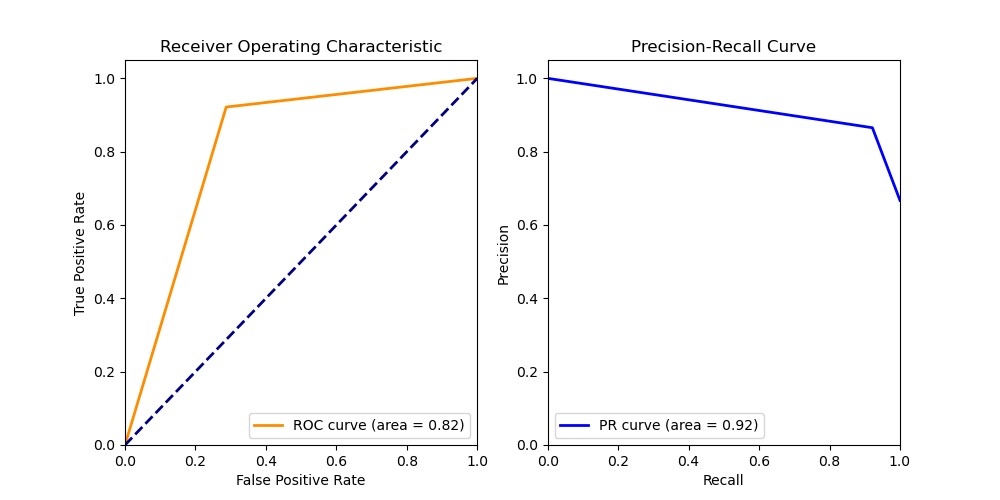